In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from numpy import loadtxt

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition, datasets, model_selection 
import xgboost as xgb

In [2]:
data_df = pd.read_csv('titanic.csv')

In [3]:
def embarked_to_num(x):
    if x == 'S':
        return 0
    elif x == 'C':
        return 1
    else:
        return 2

In [4]:
df_base = data_df[['Pclass', 'Age', 'Fare', 'Embarked', 'Survived']]

df_base['Sum_Family'] = data_df['SibSp'] + data_df['Parch']
df_base['Sex_num'] = data_df['Sex'].apply(lambda x: 1 if x == 'male' else 0)

df_base['Age_range'] = df_base['Age'] // 10
df_base['Fare_range'] = ((df_base['Fare'] // 10) * 10).astype(int)
df_base['Embarked_num'] = data_df['Embarked'].apply(lambda x: embarked_to_num(x))

df_base.head(3)

,Pclass,Age,Fare,Embarked,Survived,Sum_Family,Sex_num,Age_range,Fare_range,Embarked_num
0,3,22.0,7.2500,S,0,1,1,2.0,0,0
1,1,38.0,71.2833,C,1,1,0,3.0,70,1
2,3,26.0,7.9250,S,1,0,0,2.0,0,0


In [5]:
df_base['Age_range'].value_counts()

2.0    220
3.0    167
1.0    102
4.0     89
0.0     62
5.0     48
6.0     19
7.0      6
8.0      1
Name: Age_range, dtype: int64

In [6]:
df_main = df_base[['Pclass','Fare_range','Sum_Family','Sex_num','Age_range','Embarked_num', 'Survived']]

df_has_age = df_main[df_main['Age_range'].isnull() == False]
df_has_age = df_has_age.astype(int)
df_has_age.head(3)

,Pclass,Fare_range,Sum_Family,Sex_num,Age_range,Embarked_num,Survived
0,3,0,1,1,2,0,0
1,1,70,1,0,3,1,1
2,3,0,0,0,2,0,1


In [7]:
df_no_age = df_main[ df_main['Age_range'].isnull()==True ]
df_no_age.head(3)

,Pclass,Fare_range,Sum_Family,Sex_num,Age_range,Embarked_num,Survived
5,3,0,0,1,NaN,2,0
17,2,10,0,1,NaN,0,1
19,3,0,0,0,NaN,1,1


# xgboost

In [8]:
x_data = df_has_age[['Pclass','Fare_range','Sex_num','Sum_Family','Embarked_num']]
y_data = df_has_age['Age_range']

X_train, X_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.3, random_state=0)

[15:10:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


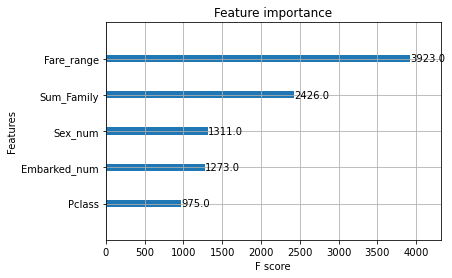

In [9]:
model_XG = xgb.XGBClassifier()
model_XG.fit(X_train, y_train)

xgb.plot_importance(model_XG)
plt.show()
# print(model_XG.score(X_test, y_test))

In [11]:
X_test

,Pclass,Fare_range,Sex_num,Sum_Family,Embarked_num
423,3,10,0,2,0
177,1,20,0,0,1
305,1,150,1,3,0
292,2,10,1,0,1
889,1,30,1,0,1
...,...,...,...,...,...
203,3,0,1,0,1
499,3,0,1,0,0
628,3,0,1,0,0
879,1,80,0,1,1


In [12]:
x_no_age = df_no_age[['Pclass','Fare_range','Sex_num','Sum_Family','Embarked_num']]

df_no_age['Age_range'] = model_XG.predict(x_no_age)
df_no_age.head()

,Pclass,Fare_range,Sum_Family,Sex_num,Age_range,Embarked_num,Survived
5,3,0,0,1,3,2,0
17,2,10,0,1,2,0,1
19,3,0,0,0,1,1,1
26,3,0,0,1,2,1,0
28,3,0,0,0,1,2,1


In [13]:
filled_df = pd.concat([df_no_age, df_has_age], axis=0)
filled_df= filled_df.sort_index()
filled_df

,Pclass,Fare_range,Sum_Family,Sex_num,Age_range,Embarked_num,Survived
0,3,0,1,1,2,0,0
1,1,70,1,0,3,1,1
2,3,0,0,0,2,0,1
3,1,50,1,0,3,0,1
4,3,0,0,1,3,0,0
...,...,...,...,...,...,...,...
886,2,10,0,1,2,0,0
887,1,30,0,0,1,0,1
888,3,20,3,0,3,0,0
889,1,30,0,1,2,1,1


In [14]:
filled_df.to_csv("titanic_age_filled.csv")